# <font color=darkblue> Probabilités numériques: Algorithme EM sur des chaines de Markov à données cachés (The Baum Welch Algorithm)</font>

Le but de ce projet est d'implémenter l'algorithme EM sur un modèle probabiliste ou les données obervables suivent des lois gaussiennes sachant les données cachés et où ces données cachés sont une chaine de Markov. Notre but sera donc d'approcher les probabilités de transitions de la chaines de Markov, les moyennes et variances des loi gaussiennes selon les différents états de la chaine et enfin les probabilités de la loi initiale de la chaine.

#### <font color=darkorange>Définition formelle du problème</font>

Plus formellement, soit $\left( X_k \right)_{ 1 \leq k \leq n}$ une chaine de Markov discrètes à valeurs dans $\left(\{1,....,r\} \right)$ de matrice de transition $Q$ et de loi initiale $\nu$. On considère que cette chaîne est uniquement observée au travers
des variables $\left(Y_k \right)_{ 1 \leq k \leq n}$ indépendantes conditionnellement à $\left( X_k \right)_{ 1 \leq k \leq n}$ et telle que pour tout
$\ 0 \leq l \leq n$
, la loi de $Y_l$ sachant $\left( X_k \right)_{ 1 \leq k \leq n}$ suit une loi $\mathcal{N}(\mu_{x_l}, v_{x_l})$
.
Le paramètre inconnu est donc ici $θ = \{\mu_{1}, . . . , ,\mu_{r}, v_{1}, . . . ,v_{r}, Q, \nu\}$.
 

In [2208]:
from graphviz import Digraph
import numpy as np
from scipy import stats
import random
from numpy.random import default_rng
rng = default_rng()



#### <font color=darkorange>  - Etape E de l'Algorithme </font>

- Dans l'étape E de l'algorithme, le but est de calculer la quantité intermédiaire de l'EM à chaque étape t de l'algorithme:

    $$Q(\theta, \theta^t) =  \mathbb{E}_{\theta^t}[\log p_{\theta}(X_{0:n}, Y_{0:n})\mid Y_{0:n}]$$ 
    
    où $p_{\theta}$ est la densité du vecteur $(X_{0},...,X_{n},Y_{1},...,Y_{0})$. On peut commencer par écrire $\log p_{\theta}(X_{0:n}, Y_{0:n})$ en fonction des paramètres du problème.

    On sait que $\forall \theta$ et $\forall x_{0},..,x_{n},y_{0},..,y_{n} \in \mathbb{R}^{n+1} \times \{1,....,r\}^{n+1} $, on a  
    $$p_{\theta}(x_{0},..,x_{n},y_{0},..,y_{n}) = p_{\theta}(y_{0},..,y_{n} \mid x_{0},..,x_{n})  f^X_{\theta}(x_{0},..,x_{n})$$
     ou $f^X$ est la densité du vecteur $(X_{0},...,X_{n})$ .

    Or sachant $(X_{0},...,X_{n})$,  $(Y_{0},...,Y_{n})$ est un vecteur de variables aléatoire indépendantes, respectivement de loi $\mathcal{N}(\mu_{x_k}, v_{x_k}), \forall k \in \{ 0, \ldots, n \}$ donc :

    $$p_{\theta}(y_{0},..,y_{n},\mid x_{0},..,x_{n}) = \prod_{k=0}^n \frac{1}{\sqrt{2\pi v_{y_i}}} \exp\left(-\frac{(y_k-\mu_{x_i})^2}{2v_{x_k}}\right) $$

    On a aussi
     
    $$f^Y_{\theta}(x_{0},..,x_{n}) = \nu(x_{0})  \prod_{k=0}^{n-1} q_{x_k,x_{k+1}}$$

    On a donc 
    
    $$p_{\theta}(x_{0},..,x_{n},y_{0},..,y_{n}) = \nu(x_{0})\prod_{k=0}^n \frac{1}{\sqrt{2\pi v_{x_k}}} \exp\left(-\frac{(y_k-\mu_{x_k})^2}{2v_{x_k}}\right) \times \prod_{k=0}^{n-1} q_{x_k,x_{k+1}}$$

    donc
    
     $$\log p_{\theta}(X_{0:n}, Y_{0:n}) = \log(\nu(X_0)) + \sum_{k=0}^n \log\left(\frac{1}{\sqrt{2\pi v_{X_k}}}\right) - \sum_{k=0}^n \frac{(Y_k - \mu_{X_k})^2}{2v_{X_k}} + \sum_{k=0}^{n-1} \log(q_{X_k} q_{X_{k+1}})$$

    Enfin on touve 
    
    $$Q(\theta, \theta^\prime) = \mathbb{E}_{\theta '}[\log p_{\theta}(X_{0:n}, Y_{0:n})\mid Y_{0:n} = y_{0:n} ] $$ 
    
    $$ =\mathbb{E}_{\theta '}[\log(\nu^{\theta}(X_0)) + \sum_{k=0}^n \log\left(\frac{1}{\sqrt{2\pi v_{X_k}}}\right) - \sum_{k=0}^n \frac{(y_i - \mu^{\theta}_{X_k})^2}{2v^{\theta}_{X_k}} + \sum_{k=0}^{n-1} \log(q^{\theta}_{X_k X_{k+1}}) \mid Y_{0:n} = y_{0:n} ]$$
    
    $$=\mathbb{E}_{\theta '}[\log(\nu^{\theta}(X_0)) \mid Y_{0:n} = y_{0:n}] + \mathbb{E}_{\theta '}[\sum_{k=0}^n \log\left(\frac{1}{\sqrt{2\pi \nu^\theta_{X_k}}}\right) - \sum_{k=0}^n \frac{(y_k - \mu^{\theta}_{X_k})^2}{2v^{\theta}_{X_k}}\mid Y_{0:n} = y_{0:n}] + \mathbb{E}_{\theta '}[\sum_{k=0}^{n-1} \log(q^{\theta}_{X_k X_{k+1}})\mid Y_{0:n} = y_{0:n}]$$
     
    $$= \sum_{i=1}^{r} \log(v^{\theta}(i)) P_{\theta '}(X_0=i \mid Y_{0:n} = y_{0:n}) - 
     \sum_{i=0}^r\sum_{k=0}^n (\log\left(\frac{1}{\sqrt{2\pi \nu^\theta_{i}}}\right) - \frac{(y_k - \mu^{\theta}_{i})^2}{2v^{\theta}_{i}}) P_{\theta '}(X_k=i \mid Y_{0:n} = y_{0:n}) + \sum_{i=0}^r \sum_{j=0}^r \sum_{k=0}^{n-1} \log(q^{\theta}_{i j}) P_{\theta '}(X_k=i, X_{k+1}=j \mid Y_{0:n} = y_{0:n})$$ 



    $\underline{Conclusion}$ : 


    $$\boxed{ \mathbb{E}_{\theta '}[\log p_{\theta}(X_{0:n}, Y_{0:n})\mid Y_{0:n} = y_{0:n} ]= \sum_{i=1}^{r} \log(\nu^{\theta}(i)) \omega^{\theta\prime}_{0}(i) - 
    \sum_{i=0}^r\sum_{k=0}^n \left(\log\left(\frac{1}{\sqrt{2\pi v^\theta_{i}}}\right) - \frac{(y_k - \mu^{\theta}_{i})^2}{2v^{\theta}_{i}} \right) \omega^{\theta\prime}_{k}(i)+ \sum_{i=0}^r \sum_{j=0}^r \sum_{k=0}^{n-1} \log(q^{\theta}_{i j}) \omega^{\theta\prime}_{k,k+1}(i,j)} $$ 
    

#### <font color=darkorange>  - Etape M de l'Algorithme </font>

- Dans l'étape M de l'algorithme, le but est de maximiser la quatité intermédiaire : c'est à dire de trouver $\theta^{(t+1)} = \mathrm{argmax}_\theta Q(\theta,\theta^{(t)})$. 
 

    En déterminant où s'annulent les dérivées partiels et grâce aux multiplicateurs de lagranges, on obtient la mise à jour et donc $\theta^{(k+1)}$:
    
    
    - $\forall i,j \in \{1,...,r\}^2, \hspace{1.5cm} \boxed{q^{\theta^{t+1}}_{ij} = \frac{\sum_{k=0}^n \omega_{k,k+1}^{\theta^t}(i,j)}{\sum_{k=0}^n \omega_k^{\theta^t}(i)}}$

    - $\forall i \in \{1,...,r\}, \hspace{2cm} \boxed{\mu^\theta_{i} = \frac{\sum_{k=0}^n y_k w_{k}^{\theta'}(i)}{\sum_{k=0}^n w_{k}^{\theta'}(i)}}$
    
    $\hspace{5cm} \boxed{v^\theta_{i} = \frac{\sum_{k=0}^n (y_k - \mu^\theta_i)^2 \omega ^{\theta^{old}}_{k}(i)}{\sum_{k=0}^n w_{k}^{\theta'}(i)}}$

    $\hspace{5cm} \boxed{\nu^\theta_{i} = \omega ^{\theta^{old}}_{0}(i)}$

    Maintenant que nous avons nos mises à jours, il nous faut des méthodes pour calculer ou approcher les probabilités $\omega_{k,k+1}^{\theta'}(i,j)$ et 
    $\omega_k^{\theta'}(i)$.
    Il existe des algorithmes capables d'approchers ces valeurs :
    

    $$\omega_{k}^{\theta'}(i)=P_{\theta '}(X_k=i \mid Y_{0:n} = y_{0:n}) = \frac{ P_{\theta'}(X_k = i, Y_{0:n} = y_{0:n})}{P_{\theta'}(Y_{0:n} = y_{0:n})}$$



    $$\omega_{k,k+1}^{\theta'}(i,j)=P_{\theta '}(X_k=i, X_{k+1}=j \mid Y_{0:n} = y_{0:n}) = \frac{ P_{\theta'}(X_k = i, X_{k+1} = j, Y_{0:n} = y_{0:n})}{P_{\theta'}(Y_{0:n} = y_{0:n})}$$ 



    Pour estimiter ces quantités, on utilise des algorithmes récursifs appelé forward procedure et backward procedure.


   On introduit,$\forall t$ et $\forall i$, les quantités :
   
    $$\alpha_i(t) = \mathrm{P}(Y_1 = y_1, \ldots, Y_t = y_t, X_t = i | \theta)$$
    $$\beta_i(t) = P(Y_{t+1} = y_1, \ldots, Y_n = y_n,| X_t = i, \theta)$$
    $$ b_i(y_k)  = P(Y_k = y_k | X_k = i, \theta)$$
    
    
    Dans le cas discret cela fonctionnerait sauf que la quantité $b_i(y_k)$ donne toujours 0 car les observations sont continues. 
    Nous allons donc supposer par abus de langague que $b_i(y_k) = \int_{y_k-\epsilon}^{y_k+\epsilon} f_{Y_k|X_k = i}(y) \,dy$ pour epsilon assez petit envirion $\epsilon = 0.01$ .

   et on obtient finalement:

   $$\boxed{\omega_{k}^{\theta'}(i) = \frac{\alpha_i(k) \beta_i(k)}{\sum_{j=0}^r \alpha_j(k) \beta_j(k)}}$$

   $$\boxed{ \omega_{k,k+1}^{\theta'}(i,j) = \frac{\alpha_i(k) a_{ij} b_{{j}}(y_{k+1}) \beta_{j}(k+1)}{\sum_{i=1}^r \sum_{w=1}^r \alpha_i(k) a_{iw}  b_{{w}}(y_{k+1}) \beta_{w}(k+1)}}$$

   Pour calculer les quantité $\alpha_i(k)$ et  $\beta_i(k)$, on utilise les algorithmes récursif forward et backward suivant:

   - $\textit{Initalisation:} $

   $$ \forall i, \alpha_i(1) = \pi_i b_i(y_1)$$

   - $\textit{Récursion:}$

   $$\alpha_{i}(k+1) = \left[\sum_{j=1}^r \alpha_{j}(k)a_{ij}\right]b_i(y_{k+1})$$

   - $\textit{Initalisation:}$
   
  $$\forall i, \beta_i(n) = 1 $$

   - $\textit{Récursion:}$

   $$\beta_i(k) = \sum_{j=1}^r a_{ij}b_j(y_{k+1})\beta_{j}(k+1)$$

   On pose la matrice alpha de taille $n\times r$ tel que $a_{ki} = \alpha_{i}(k)$
   et la matrice b de taille $n\times r$ tel que $b_{ki} = b_{i}(k)$

   Par ailleurs on a besoin de ces initalisations pour que la récursion soit juste. 
   Ces récursions sont logique - > annexe


 
 

#### <font color=darkorange>  - Partie application et execution de l'algorithme EM </font>

#### <font color=darkorange>  I - Simulations des obervations </font>




Notre but va donc être de fixer les paramètres de $\theta$ de notre modèle et simuler des observations sous ce theta fixé. Nous allons ensuite vérifier que notre algorithme EM approxime bien nos paramètres de theta en supposant connues seulement les observations.

<font color=red> - Simulation de n observations d'une chaine de markov de matrice de transition Q, loi initiale v et espace d'états E. </font>

In [2209]:
""" Simulation est une fonction qui simule n_steps pas d'une chaine de markov sur un espace détat e, de loi initiale nu, de matrice de transition Q"""
def Simulation(Q,nu,e,n_steps): 
    # Q : matrice de transition (array de float dimension  r * r) 
    # nu :  loi initiale (array de float dimension r) 
    # e : liste_d'etats (array de int dimension r)
    #n_steps : nombre de pas de la chaines à simuler (int)

    X = np.zeros(n_steps,dtype = np.int64)
    current_state = rng.choice(e,p = nu)
    for i in range(n_steps): 
        X[i] = current_state
        current_state = rng.choice(e,p = Q[current_state - 1])
    return X


In [2210]:
""" Simulation observations est une fonction qui simule les obersvations Yi sachant les états Xi d'une chaine de markov sur un espace détat e, 
de loi initiale nu, de matrice de transition Q, de moyennes des etats means et variance vars"""


def Simulation_Observation(chaine_states,means,vars):  
    # chaine_states -> etats de la chaine pour simuler les observations -> array de int
    # means - > liste des mean_x (float)
    # var -> liste des var_x (float)
    
    Y = np.zeros(chaine_states.size,dtype = np.float64)
    for i in range(chaine_states.size): 
        normale_i = stats.norm(loc = means[chaine_states[i] - 1], scale = np.sqrt(vars[chaine_states[i] - 1]))
        Y[i] = normale_i.rvs()
    return Y


#### <font color=darkorange>  II - Calcul des quantités omegas </font>




<font color=red>  - Calcul de la matrice B </font>

Notre matrice B sera de la forme : 

\begin{pmatrix}
b_1(y_1) & b_2(y_1) & b_r(y_1) \\
b_1(y_2) & b_2(y_2) & b_r(y_2) \\
.      &   .    &   .    \\
b_1(y_n) & b_2(y_n) & b_r(y_n) \\

\end{pmatrix}


In [2211]:
""" create_B est une fonction qui crée la matrice B des paramètres acutels de l'EM grâce à la formule de récurrence """

def create_B(Y,means,vars):
    # Y -> observations
    # means -> moyennes des etats
    # vars -> variances des etats
    
    n = Y.size
    r = means.size 
    B = np.zeros([n,r],dtype = np.float64) # matrice B
    for i in range(r):
        normal_law = stats.norm(loc = means[i], scale = np.sqrt(vars[i]))
        B[:,i] = normal_law.pdf(Y) # valeur de la densité en y
    return B

<font color=red>  - Calcul de la matrice Alpha </font>

Notre matrice $\alpha$ est de la forme : 

\begin{pmatrix}
\alpha_1(1) & \alpha_2(1) & \alpha_r(1) \\
\alpha_1(2) & \alpha_2(2) & \alpha_r(2) \\
.      &   .    &   .    \\
\alpha_1(n) & \alpha_2(r) & \alpha_r(n) \\

\end{pmatrix}


In [2212]:
def create_alpha(Y,theta):

    Q,nu,means,vars = theta
    
    """ create_alpha est une fonction qui crée la matrice alpha 
    des paramètres acutels de l'EM grâce à la formule de récurrence """

    # Y -> observations
    # Q -> matrice de transitions de la chaine de markov
    # nu loi initiale de la chaine
    # means -> moyennes des etats
    # vars -> variances des etats

    n = Y.size # nombre d'obeservations
    r = means.size # nombre d'états
    B = create_B(Y,means,vars) # matrice beta
    A = np.zeros([n,r]) # matrice alpha
    A[0,:] = nu * B[0,:]
    for k in range(1,n):
        for i in range(r):
            A[k,i] = (A[k-1,:] @ Q[:,i]) * B[k,i] #reccurrence
    return A

<font color=red>  - Calcul de la matrice Beta </font>

Notre matrice $\beta$ est de la forme : 

\begin{pmatrix}
\beta_1(1) & \beta_2(1) & \dots & \beta_r(1) \\
\beta_1(2) & \beta_2(2) & \dots & \beta_r(2) \\
\vdots      & \vdots      & \ddots & \vdots      \\
\beta_1(n) & \beta_2(r) & \dots & \beta_r(n) \\

\end{pmatrix}

In [2213]:
def create_beta(Y,theta):

    Q,nu,means,vars = theta

    """ create_beta est une fonction qui crée la matrice 
    B des paramètres acutels de l'EM grâce à la formule de récurrence """

    # Y -> observations
    # Q -> matrice de transitions de la chaine de markov
    # nu loi initiale de la chaine
    # means -> moyennes des etats
    # vars -> variances des etats
    
    n = Y.size # nombre d'observations
    r = nu.size # nombre d'états
    B = create_B(Y,means,vars)  # matrice B  
    beta = np.zeros([n,r]) # matrice beta
    beta[-1,:] = np.ones(r)

    for k in range(n-2, -1, -1):
        for i in range(r):
            beta[k,i] = np.sum(beta[k+1,:] * B[k+1,:] * Q[i,:]) # reccurrence
    return beta

<font color=red>  - Calcul des matrices Omega </font>

Nos matrices $\omega$ sont de la forme : 

La matrice des $\omega_k(i)$

\begin{pmatrix}
\omega_1(1) & \omega_2(1) & \dots & \omega_r(1) \\
\omega_1(2) & \omega_2(2) & \dots & \omega_r(2) \\
\vdots      & \vdots      & \ddots & \vdots      \\
\omega_1(n) & \omega_2(r) & \dots & \omega_r(n) \\

\end{pmatrix}

la seconde matrice des $\omega_{k,k+1}(i)$ est une liste de matrice de la forme:

$$
\begin{bmatrix}
    \begin{pmatrix}
        \omega_{1,2}(1,1) & \omega_{1,2}(1,2) & \dots & \omega_{1,2}(1,3) \\
        \omega_{1,2}(2,1) & \omega_{1,2}(2,2) & \dots & \omega_{1,2}(2,3) \\
        \vdots      & \vdots      & \ddots & \vdots      \\
        \omega_{1,2}(r,1) & \omega_{1,2}(r,2) & \dots & \omega_{1,2}(r,r) \\
    \end{pmatrix}, \dots ,
    &
    \begin{pmatrix}
        \omega_{n-1,n}(1,1) & \omega_{n-1,n}(1,2) & \dots & \omega_{n-1,n}(1,3) \\
        \omega_{n-1,n}(2,1) & \omega_{n-1,n}(2,2) & \dots & \omega_{n-1,n}(2,3) \\
        \vdots      & \vdots      & \ddots & \vdots      \\
        \omega_{n-1,n}(r,1) & \omega_{n-1,n}(r,2) & \dots & \omega_{n-1,n}(r,r) \\
    \end{pmatrix}
\end{bmatrix}
$$


In [2214]:
def omega_now(Y,theta):   

    Q,nu,means,vars = theta

    """ omega_now est une fonction qui permet de calculer les coefficient omega"""

    # Y -> observations
    # Q -> matrice de transitions de la chaine de markov
    # nu loi initiale de la chaine
    # means -> moyennes des etats
    # vars -> variances des etats
 
    n = Y.size # nombre d'observations
    r = nu.size # nombre d'états
    omega = np.zeros([n,r]) # matrice omega
    alpha = create_alpha(Y,theta) # matrice alpha
    beta = create_beta(Y,theta) # matrice beta
    for k in range(n):
        for i in range(r):
            omega[k,i] = (alpha[k,i] * beta[k,i]) 
        omega[k,:] = omega[k,:] / np.sum(omega[k,:])
    return omega



In [2215]:
def omega_next(Y,theta):   
    
    Q,nu,means,vars = theta

    """ omega_now est une fonction qui permet 
    de calculer les coefficient omega"""

    # Y -> observations
    # Q -> matrice de transitions de la chaine de markov
    # nu -> loi initiale de la chaine
    # means -> moyennes des etats
    # vars -> variances des etats

    n = Y.size # nombre d'observations
    r = nu.size   # nombre d'états
    alpha = create_alpha(Y,theta) # matrice alpha
    beta = create_beta(Y,theta) # matrice beta
    B = create_B(Y,means,vars) # matrice B
    N = Q.shape[0]
    omega = np.zeros((n-1,N,N))  # matrice omega

    for k in range(n-1):
        for i in range(r):
            for j in range(r):
                omega[k,i,j] = np.log(alpha[k,i] * Q[i,j] * B[k+1,j]  * beta[k+1,j]) # reccurence
        omega[k, :, :] = omega[k, :, :] / np.sum(omega[k, :, :]) 
    return omega

<font color=red> - Très important !!! Le rescaling </font>

Première approximation, les betas....

Le rescaling est une étape importante de l'algorithme EM pour les modèles de Markov Caché.

L'étape E de l'algorithme EM consiste à calculer la distribution des variables cachées $X_1, X_2, ..., X_n$ conditionnellement aux données observées $Y_1, Y_2, ..., Y_n$ et aux paramètres courants $\theta^{(t)}$, où $t$ est le numéro d'itération actuel de l'algorithme. Cette distribution conditionnelle peut être calculée à l'aide de l'algorithme de Forward-Backward.

Cependant, pour éviter les problèmes numériques d'underflow ou d'overflow, il est nécessaire de renormaliser les probabilités obtenues par l'algorithme de Forward-Backward. En effet, les probabilités de \alpha, \beta et b  peuvent être très petites ou très grandes, et lorsqu'on multiplie plusieurs probabilités ensemble, les résultats peuvent rapidement devenir imprécis.

Le rescaling consiste donc à renormaliser les probabilités obtenues dans l'algorithme de Forward-Backward pour chaque instant $k$ de la chaîne de Markov cachée, de telle sorte que la somme des probabilités pour chaque état soit égale à 1. Cela permet de maintenir une précision numérique suffisante pour les calculs ultérieurs.

On renormalise donc non seulement les alpha, mais aussi les beta, nous considérerons donc toujours dorénavant les alpha_chapeau, beta chapeau...

#### <font color=darkorange>  III - Implémentation de l'algo EM </font>

Dans cette partie, on code l'algorithme EM d'abord en mettant seulement à jours, la moyenne puis la variance. On test cette algorithme pour 3 modèles simples et on vérifie qu'on a bien augmentation de la vraissemblance. On compare aussi la convergence de l'EM pour différents paramètres initiales et un nombre différents d'observations.


#### <font color=pink> MODIFICATION </font>


On calcule la vraissemblance sachant des données cachées car la vraissemblance des observations est trop compliqué à calculer, c'est la somme sur toutes les possibiltiés de transtions de la chaines des ..., et comme nous connaisons justement les données cachées dans nos exemples il n'y pas de problèmes.
 $$ \log p_\theta(Y_1=y_1,\dots,Y_n=y_n) = \sum_{i = 1}^r \alpha_n(i)$$


In [2216]:
def log_likelihood(Y,theta):

    Q,nu,means,vars = theta
    """ Cette fonction calcule n_iters itérations de l'algorithme EM avec
    comme paramatètres initiales means_init et vars_init"""

    """ 
    Input
    ---------
    Y -> Observations
    theta -> (Q_init,nu_init,means_init,vars_init)
    Q -> matrice de transitions de la chaine de markov
    nu -> loi initiale de la chaine
    means -> moyennes des etats
    vars -> variances des etats

    Outputs
    ----------
    log_likehood -> log_vraissemblance des observations pour theta
    """
    n = Y.size
    alpha = create_alpha(Y,theta)

    return np.log(np.sum(alpha[n-1,:]))


In [2217]:
def log_likelihood_monte_carlo(Y,theta,n_sample): 
    from itertools import product

    Q,nu,means,vars = theta
    """ fonction qui permet de calculer la log vraissemblance 
    sachant les etats de la chaine """
    
    # Y -> observations
    # Q -> matrice de transitions de la chaine de markov
    # nu loi initiale de la chaine
    # means -> moyennes des etats
    # vars -> variances des etats

    n = Y.size # nombre d'observations
    r = means.size   # nombre d'états
    E = np.arange(r) + 1
    monte_carlo = 0.

    for k in range(n_sample):
        sample_markov = Simulation(Q,nu,E,n)
        for i in range(n):
            monte_carlo = monte_carlo + np.log(stats.norm.pdf(Y[i],loc = means[sample_markov[i] - 1], scale = np.sqrt(vars[sample_markov[i] - 1])))
        
    return monte_carlo/n_sample

In [2218]:
def EM_test_simple(Y,theta_init,nb_iters,states = []):
    

    Q_init,nu_init,means_init,vars_init = theta_init
    """ Cette fonction calcule n_iters itérations de l'algorithme EM avec
    comme paramatètres initiales means_init et vars_init"""

    """ 
    Input
    ---------
    Y -> Observations
    theta init -> (Q_init,nu_init,means_init,vars_init)
    Q_init -> matrice de transitions de la chaine de markov
    nu_init -> loi initiale de la chaine
    means_init -> moyennes des etats
    vars_init -> variances des etats

    Outputs
    ----------
    means -> moyenne après nb_iters itérations
    vars -> variance après nb_iters itérations
    liste_means -> liste des moyennes de chaque itérations
    liste_vars -> liste des variances de chaque itérations

    """

    n = Y.size # nombre d'observations
    r = nu_init.size  # nombre d'états
    y = Y # liste d'observations
    Q = Q_init # matrice de transtion
    nu = nu_init # liste de loi initiale
    means = means_init # moyenne à itérer
    vars = vars_init # variance à itérer
    liste_means = [] # liste des moyennes succesives
    liste_vars = [] # liste des variances successives
    log_likelihoods = []

    for i in range(nb_iters):
        theta_prime = (Q,nu,means,vars) # theta courant
        omega = omega_now(y,theta_prime) # mise à jour de omega
        liste_means.append(np.array(means)) 
        liste_vars.append(np.array(vars))
        for j in range(r):
            means[j]  = np.sum(y*omega[:,j]) / np.sum(omega[:,j]) # mise à jour des moyennes 
            vars[j]  = np.sum(((y - means[j])**2) * omega[:,j]) / np.sum(omega[:,j]) # mises à jours des variances
        theta = (Q,nu,means,vars) #nouveau theta
        log_likelihoods.append(log_likelihood(Y,theta))
    return means,vars,np.array(liste_means),np.array(liste_vars),np.array(log_likelihoods)

<font color=red> - Test pour différents modèles et comparaisons en fonction du nombres d'observations, itérations, conditions initales</font>

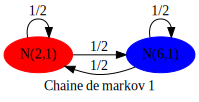

In [2219]:
from graphviz import Digraph

# créer le graphe
dot = Digraph(comment='Chaines de Markov')
dot.attr(label='Chaine de markov 1')
dot.attr(rankdir='LR') # orientation horizontale

# ajouter les états
dot.node('N(2,1)', style='filled', color='red')
dot.node('N(6,1)', style='filled', color='blue')

# ajouter les transitions
dot.edge('N(2,1)', 'N(2,1)', label='1/2')
dot.edge('N(2,1)', 'N(6,1)', label='1/2')
dot.edge('N(6,1)', 'N(6,1)', label='1/2')
dot.edge('N(6,1)', 'N(2,1)', label='1/2')

# afficher le graphe
dot.graph_attr['size'] = '5,3'
dot


In [2220]:
"""fonction affichage des graphes"""

import matplotlib.pyplot as plt
import seaborn as sns

def affichage(Y,means,vars,liste_means,liste_vars,nb_iters,real_means,real_vars):
    fig, (ax1,ax2,ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (13,4), layout = "tight")
    abs = np.zeros(Y.size)
    ax1.scatter(Y,abs,label = "Observations $Y_{ 1 \leq k \leq n}$", color = "green", s= 10)
    for k in range(real_means.size):
        normal_k = stats.norm(loc = means[k], scale = np.sqrt(vars[k]))
        abs_k = np.linspace(means[k]-5,means[k]+5,100)
        ax1.plot(abs_k,normal_k.pdf(abs_k),label = "$\mathcal{N}$" + f"$(\mu_{k}, v_{k})$") 
         
    ax1.scatter(real_means,np.zeros(real_means.size),color = "purple",label = "real means")
    ax1.legend()

    for k in range(real_means.size):
        ax2.scatter(np.arange(nb_iters),liste_means[:,k],label = f"$\mu_{k}$",s = 10 )
        ax2.axhline(real_means[k],color = "yellow")
        #ax2.set_yscale('log')
        ax2.set_title("Moyennes en fonction du nombre d'itérations")

    ax2.legend()

    for k in range(real_means.size):
        ax3.scatter(np.arange(nb_iters),liste_vars[:,k],label = f"$v_{k}$", s = 10 )
        ax3.axhline(real_vars[k],color = "yellow")
        #ax3.set_yscale('log')
        ax3.set_title("Variances en fonction du nombre d'itérations")

    ax3.legend()

    fig.suptitle(f"Graphes pour la chaine de Markov avec means = {real_means}, vars = {real_vars}")
    plt.show()


In [2221]:
""" Chaine de markov 1 """

E = np.array([1,2]) # ensemble d'états de la chaine de markov 1
nu = np.array([1/2,1/2]) # loi initial de la chaine de markov 1
Q = np.array([[1/2,1/2],[1/2,1/2]]) # matrice de transitions de la chaine de markov 1
nb_observations = 100 # nombre d'observations de la HMM de la chaine de markov 1
means = np.array([2,6]) # moyennes des loi normales associées aux états de E de la chaine de markov 1
vars = np.array([1,1]) # variances des loi normales associées aux états de E de la chaine de markov 1

X = Simulation(Q,nu,E,nb_observations) # simulation de la chaine de markov de la HMM
Y = Simulation_Observation(X,means,vars) # simulation des observations de la HMM

In [2222]:
""" On fixe les observations pour la chaine de markov 1"""

X = liste = np.array([2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 
1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 
1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2])


Y = np.array([6.44033042, 4.2847419, 1.93632836, 4.76273427, 2.64302409, 7.82913449, 3.74115053, 3.46962185, 4.28355586, 7.61079951, 
1.50276133, 6.76726358, 6.49654948, 6.58249132, 6.09470314, 6.06702041, 5.82179846, 4.92682039, 6.55042853, 4.80265462, 6.07423918, 
5.88381469, 4.78754948, 3.01511104, 1.74413282, 4.98960058, 1.40177193, 6.59320222, 0.9210667, 5.99476264, 1.92776537, 2.92689152, 
7.54615554, 3.20463922, 1.47267206, 2.21587579, 1.13199892, 1.40259304, 5.14559622, 6.82211199, 2.47101, 1.93218907, 1.74440766, 
0.44696592, 6.54007918, 5.2506151, 1.34322381, 3.47594181, 6.4019291, 2.55230954, 4.92055968, 7.13888988, 5.72851315, 1.77532587, 
6.75499771, 2.60967392, 7.32959577, 5.56440827, 3.71775215, 1.79035071, 5.17020616, 6.81067634, 1.32205268, 0.44593896, 2.262454, 
6.15326925, 2.44227689, 0.88095581, 2.470302, 5.65412086, 3.45672729, 2.08081229, 0.68014062, 3.50375968, 2.72798992, 2.30593604, 
2.00491006, 5.20288642, 0.312501, 2.53242334, 5.1756694, 6.72760606, 2.4912603, 1.37996453, 6.58235944, 5.42887731, 2.20932435, 
6.50636919, 5.31541046, 5.18144236, 5.71730387, 3.55276114, 0.60094261, 6.29564489, 0.30832694, 6.94884775, 2.42562331, 2.58592196, 
3.47152026, 8.10344694])

 moyennes estimées = [6.02387698 2.1203574 ]
 variances estimées = [0.90170607 0.97625497]


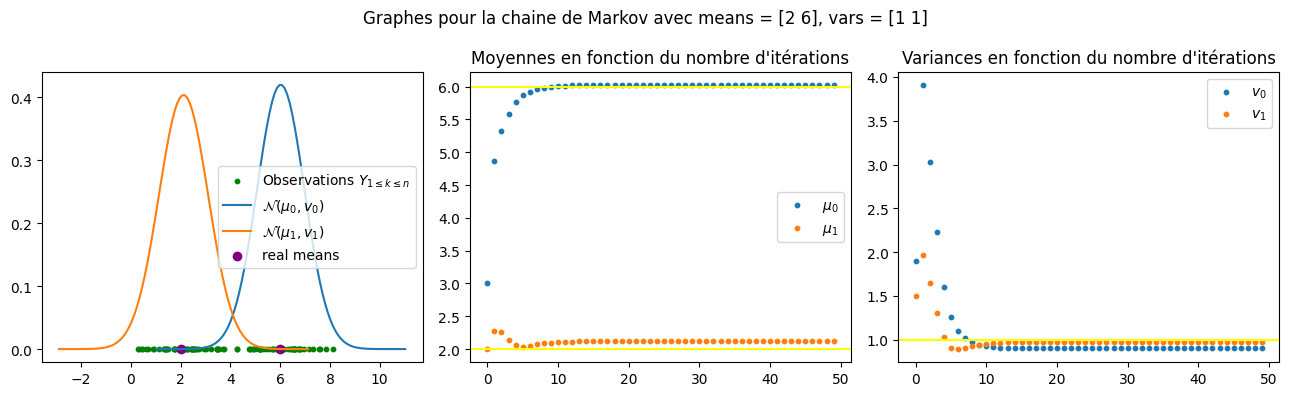

<function matplotlib.pyplot.legend(*args, **kwargs)>

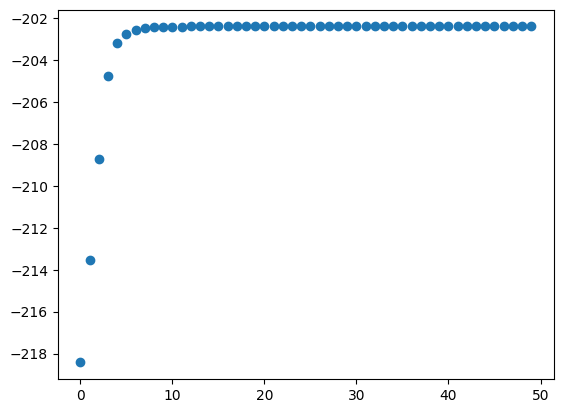

In [2223]:
""" test pour une quantité intiale """

means_init = np.array([3.,2.]) # moyennes initales de l'EM
vars_init = np.array([1.9,1.5]) # variances initales de l'EM
nb_iters = 50 # nombre d'itérations de l'EM
theta_init = (Q,nu,means_init,vars_init) # theta initiale de l'EM

means_result,vars_result,liste_means,liste_vars,log_likelihoods = EM_test_simple(Y,theta_init,nb_iters,X) # execution de l'algorithme EM
print(f" moyennes estimées = {means_result}") # moyennes estimées
print(f" variances estimées = {vars_result}") # variances estimés
affichage(Y,means_result,vars_result,liste_means,liste_vars,nb_iters,means,vars)
plt.scatter(np.arange(nb_iters),log_likelihoods, label = "évolution de la log vraissemblance en fonction des itérations")
plt.legend


 moyennes estimées = [2.1203574  6.02387698]
 variances estimées = [0.97625497 0.90170607]


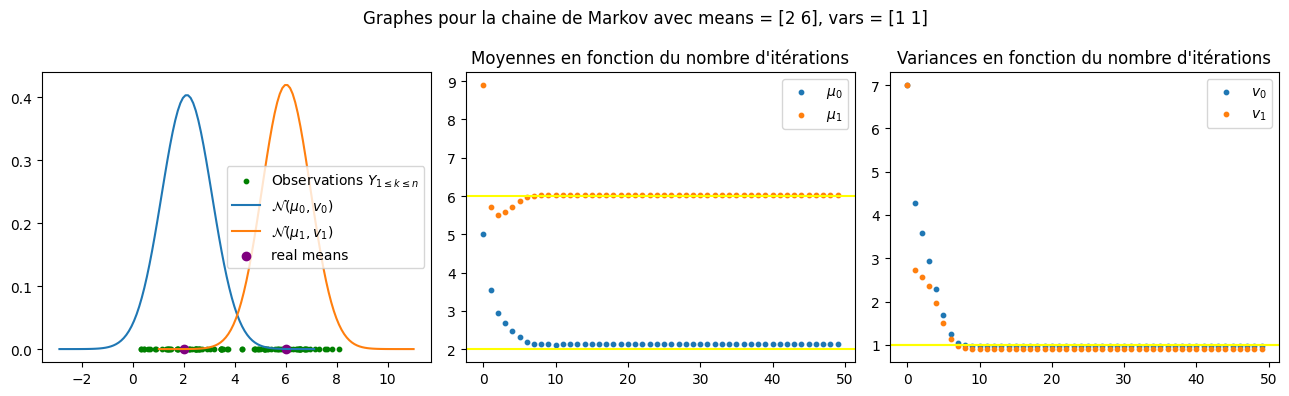

In [2224]:
""" test pour une seconde donnée initiale"""

means_init = np.array([5.,8.9]) # moyennes initales de l'EM
vars_init = np.array([7.,7.]) # variances initales de l'EM
nb_iters = 50 # nombre d'itérations de l'EM
theta_init = (Q,nu,means_init,vars_init) # theta initiale de l'EM

means_result,vars_result,liste_means,liste_vars,log_likelihoods = EM_test_simple(Y,theta_init,nb_iters,X) # execution de l'algorithme EM
print(f" moyennes estimées = {means_result}") # moyennes estimées
print(f" variances estimées = {vars_result}") # variances estimés
affichage(Y,means_result,vars_result,liste_means,liste_vars,nb_iters,means,vars)

#### <font color=pink> Observation chaine de markov 1

</font>

Dans le cas de la chaine de markov 1, on a convergence vers les bons paramètres de moyenens [2,6] et variances [1,1], avec pour conditions initales [3,2], [1.9,1.5] et nombre d'observations 100 et nombres d'itérations 100. La convergence de l'EM est rapide dans le cas de cette chaine de markov et pour beaucoup de valeurs initiales. On observe aussi qu'on a bien augmentation le la log vraissemblance des deonnées observés en fonction du nombre d'itération de l'EM ce qui est donc cohérent.

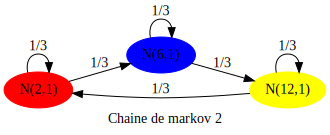

In [2225]:
from graphviz import Digraph

# créer le graphe
dot = Digraph(comment='Chaines de Markov')
dot.attr(label='Chaine de markov 2')
dot.attr(rankdir='LR') # orientation horizontale

# ajouter les états
dot.node('N(2,1)', style='filled', color='red')
dot.node('N(6,1)', style='filled', color='blue')
dot.node('N(12,1)', style='filled', color='yellow')

# ajouter les transitions
dot.edge('N(2,1)', 'N(6,1)', label='1/3')
dot.edge('N(6,1)', 'N(12,1)', label='1/3')
dot.edge('N(12,1)', 'N(2,1)', label='1/3')
dot.edge('N(2,1)', 'N(2,1)', label='1/3')
dot.edge('N(6,1)', 'N(6,1)', label='1/3')
dot.edge('N(12,1)', 'N(12,1)', label='1/3')

# afficher le graphe
dot.graph_attr['size'] = '5,3'

dot


In [2226]:
""" Chaine de markov 2 """

Q = np.array([[1/3,1/3,1/3],[1/3,1/3,1/3],[1/3,1/3,1/3]])
nu = np.array([1/3,1/3,1/3])
E = np.array([1,2,3])
nb_observations = 100
means = np.array([2,6,12])
vars = np.array([1,1,1])
X = Simulation(Q,nu,E,nb_observations)
Y = Simulation_Observation(X,means,vars)


In [2227]:
""" on fixe les ibservations pour la chaine de markov 2"""

X = liste = np.array([2, 3, 1, 2, 2, 1, 1, 2, 1, 3, 2, 1, 1, 3, 3, 1, 1, 3, 2, 1, 2, 1, 2, 1, 2, 1, 3, 2, 1, 2, 3, 1, 
1, 2, 3, 1, 3, 3, 3, 3, 1, 1, 2, 2, 1, 3, 1, 3, 2, 1, 2, 3, 3, 1, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 3, 1, 3, 2, 1, 3, 2, 2, 
3, 1, 3, 1, 2, 2, 1, 2, 1, 3, 2, 1, 1, 3, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 2, 2])


Y = np.array([5.81802249, 11.69367057, 2.68574092, 4.55752785, 5.34931532, 0.13928174, 2.69307372, 7.15158269, 1.09677025, 11.74561886, 6.77199527, 
2.04497225, 2.8936064, 11.15565071, 12.69268183, 2.24706256, 2.5482996, 11.56071865, 6.36594685, 2.68863562, 6.96224223, 1.777695, 6.12203423, 
4.0988966, 7.5141372, 3.14035432, 10.4247132, 6.3190614, 0.69792561, 7.22847796, 13.40195705, 2.50921293, 3.27563491, 7.15298197, 11.32799985, 
4.89311415, 12.21339235, 13.44196113, 11.90829568, 12.48510946, 1.01362407, 2.86169211, 7.70225037, 6.37010958, 0.21880041, 10.26989708, 
-0.18757232, 11.38178989, 5.71308367, 1.9188115, 6.89250015, 10.17364791, 12.66094741, 1.53898636, 2.69830293, 1.47492197, 2.88022664, 
4.72688716, 13.25039411, 1.19764, 2.69275328, 6.88035574, 11.16874767, 2.424957, 2.36467702, 12.57121031, 2.54469198, 13.21567884, 
5.88071266, 2.21464592, 12.73220171, 5.95772408, 4.81128173, 12.55352217, 0.58694302, 10.78911288, 2.62008334, 6.22229308, 7.12393978, 
2.51937257, 6.26373595, 2.36203353, 12.43386117, 5.19121218, 3.50958365, 3.02164584, 12.20635498, 11.25253867, 2.18261491, 2.23019893, 
1.39074743, 2.44960915, 2.84181533, 5.37646704, 6.07558586, 6.96268676, 6.75986948, 11.38882102, 5.1924105, 6.1873079])

 moyennes = [ 2.16097409  6.19930391 11.9296337 ]
 variances = [0.91768183 0.7451932  0.86514576]


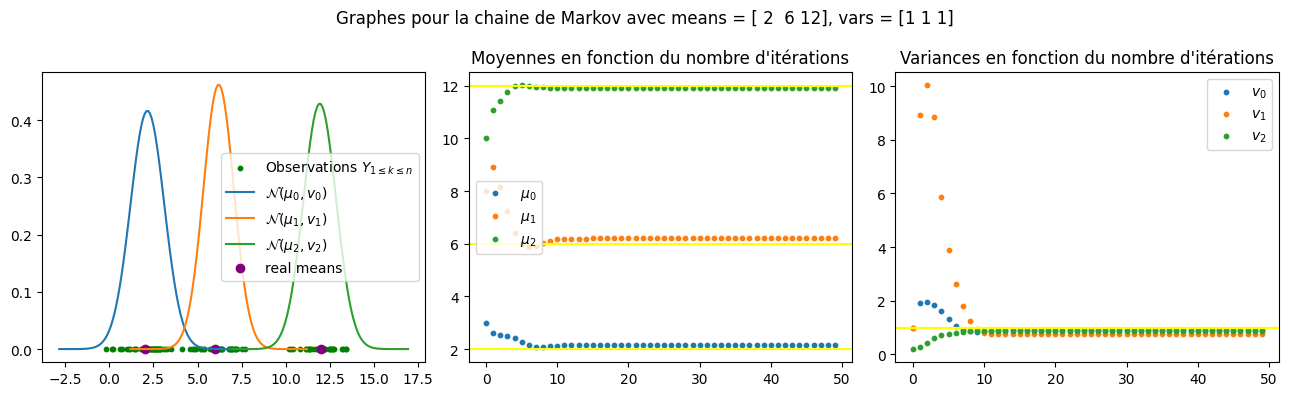

In [2228]:
means_init = np.array([3.,8.,10.])
vars_init = np.array([1.,1.,0.2])
nb_iters = 50
theta_init = (Q,nu,means_init,vars_init)

means_result,vars_result,liste_means,liste_vars,log_likelihoods = EM_test_simple(Y,theta_init,nb_iters,X)
print(f" moyennes = {means_result}")
print(f" variances = {vars_result}")
affichage(Y,means_result,vars_result,liste_means,liste_vars,nb_iters,means,vars)

Pour une chaine de markov un peu plus complique, on a encore convergence de vers les bons paramètres pour les valeurs d'initalisation [3,8,10], [1,1,0.2].
Nous allons cependant avec la 4ème chaine de markov que la convergence de l'EM dépend beaucoupd des conditions initiales et du nombres d'observations.

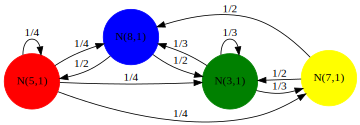

In [2229]:
from graphviz import Digraph
from scipy.stats import norm

dot = Digraph()

# Définir le style des nœuds et l'orientation du graphique
dot.attr('node', shape='circle', style='filled')
dot.attr(rankdir='LR')

# Définir les moyennes et les écarts-types pour chaque état
means = [5, 8, 3, 7]
stds = [1, 1, 1, 1]

# Définir les symboles pour chaque état en utilisant la notation de la loi normale
symbols = [f"N({mean},{std})" for mean, std in zip(means, stds)]

# Ajouter les noeuds avec les symboles
for i, sym in enumerate(symbols):
    dot.node(str(i+1), label=f"{sym}", color=["red", "blue", "green", "yellow"][i])

# Ajouter les arcs
dot.edge("1", "1", label="1/4")
dot.edge("1", "2", label="1/4")
dot.edge("1", "3", label="1/4")
dot.edge("1", "4", label="1/4")
dot.edge("2", "1", label="1/2")
dot.edge("2", "3", label="1/2")
dot.edge("3", "2", label="1/3")
dot.edge("3", "3", label="1/3")
dot.edge("3", "4", label="1/3")
dot.edge("4", "2", label="1/2")
dot.edge("4", "3", label="1/2")

dot.graph_attr['size'] = '5,3'

dot



In [2230]:
""" Chaine de markov 3 """

Q = np.array([[1/4,1/4,1/4,1/4],[1/2,0,1/2,0],[0,1/3,1/3,1/3],[0,1/2,1/2,0]])
nu = np.array([1/4,1/4,1/4,1/4])
E = np.array([1,2,3,4])
nb_observations = 100
means = np.array([5,8,3,7])
vars = np.array([1,1,1,1])

X = Simulation(Q,nu,E,nb_observations)
Y = Simulation_Observation(X,means,vars)

In [2231]:
"on fixe les observations de la chaine markov 3"

X = np.array([1, 4, 2, 3, 3, 2, 3, 3, 4, 3, 4, 2, 1, 1, 2, 3, 2, 1, 1, 3, 4, 3, 3, 2, 3, 4, 2, 1, 4, 2, 1, 3, 3, 3, 4, 3, 4, 3, 4, 2, 3, 4, 3, 
              4, 2, 3, 3, 3, 3, 4, 2, 3, 3, 2, 3, 2, 3, 2, 1, 2, 1, 3, 3, 4, 2, 3, 2, 3, 4, 3, 2, 1, 2, 3, 2, 1, 3, 3, 4, 2, 3, 3, 4, 3, 4, 3, 
              3, 4, 2, 3, 3, 3, 2, 3, 4, 3, 3, 2, 3, 4.])

Y = np.array([5.11194259, 8.20922791, 7.53111261, 1.19289937, 3.4743243, 6.54162242, 2.39547626, 3.65547418, 6.9585683, 1.92077484, 6.88243649, 
              8.03138763, 5.84401745, 4.69813403, 8.90885544, 3.3746174, 7.28269665, 6.72255545, 6.18287095, 3.51863385, 8.20274739, 2.70466828, 
              1.77670115, 8.40532336, 2.95894924, 5.20187863, 7.77628773, 5.48203256, 5.05118653, 8.52198821, 5.97657106, 2.51233552, 3.26069615, 
              2.82818055, 8.75139656, 3.05329224, 6.90897871, 2.79813567, 7.22058114, 6.80888289, 2.94606275, 6.66120234, 3.42813063, 8.28034198, 
              8.47310153, 3.17681426, 1.99451463, 4.46529009, 2.81048279, 6.75189313, 6.34274567, 4.27151983, 3.01850572, 7.88922584, 1.19435594, 
              7.7096871, 4.98370914, 7.49736254, 5.83640482, 6.91131552, 3.75234604, 2.26837247, 2.37196398, 6.62098737, 6.83277702, 4.54503446, 
              8.36884545, 4.52955822, 7.75764507, 3.38044861, 8.24849366, 3.47909293, 8.2536528, 2.25080165, 8.634826, 4.94422956, 2.87030309, 
              2.89185592, 6.95216368, 8.12929073, 2.97511821, 3.19998416, 6.01741346, 4.63749581, 6.05124719, 3.27288723, 3.87784532, 5.57817787, 
              8.1988576, 0.55772852, 2.98536999, 2.67406837, 7.41558581, 1.76785938, 7.86978809, 4.13598786, 2.60114259, 8.30023652, 3.23364487, 7.47018461])

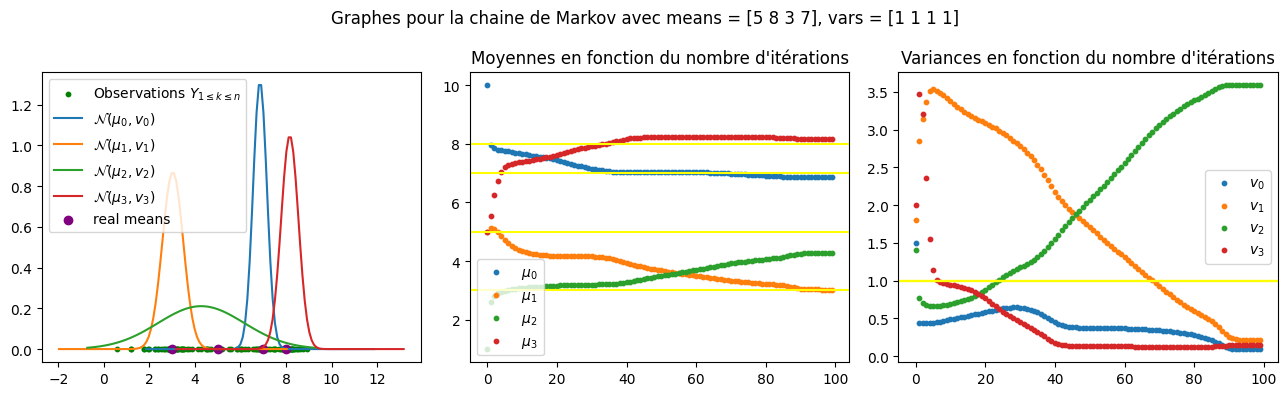

 moyennes = [6.8575015  3.02912725 4.27365806 8.16570655]
 variances = [0.09221189 0.21094537 3.58945086 0.1448577 ]


In [2232]:
means_init = np.array([10.,5.,1.,5.])
vars_init = np.array([1.5,1.8,1.4,2.])
nb_iters = 100
theta_init = (Q,nu,means_init,vars_init)

means_result,vars_result,liste_means,liste_vars,log_likelihoods = EM_test_simple(Y,theta_init,nb_iters,X)
affichage(Y,means_result,vars_result,liste_means,liste_vars,nb_iters,means,vars)
print(f" moyennes = {means_result}")
print(f" variances = {vars_result}")

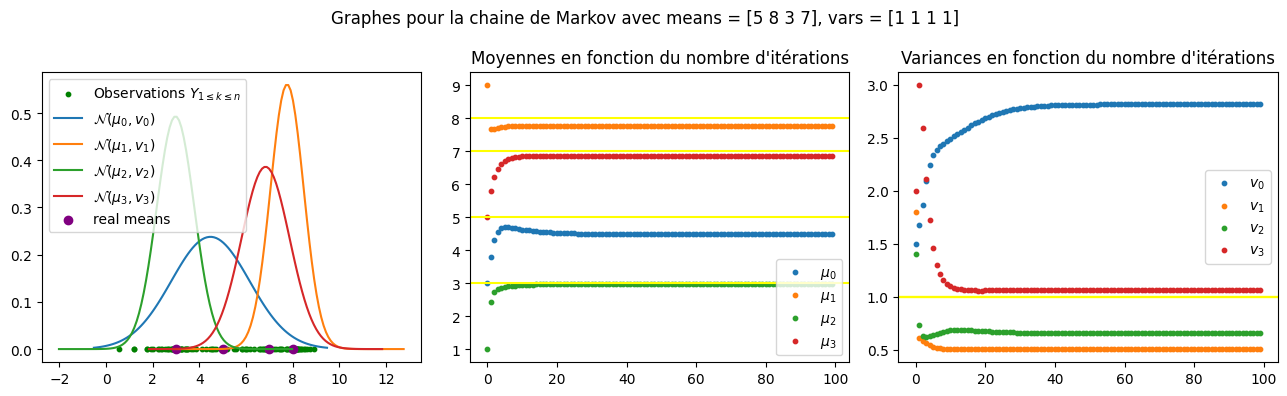

 moyennes = [4.47985472 7.7676605  2.98161694 6.84416055]
 variances = [2.81570814 0.50629741 0.6548635  1.06711984]


In [2233]:
means_init = np.array([3.,9.,1.,5.])
vars_init = np.array([1.5,1.8,1.4,2.])
nb_iters = 100
theta_init = (Q,nu,means_init,vars_init)

means_result,vars_result,liste_means,liste_vars,log_likelihoods = EM_test_simple(Y,theta_init,nb_iters,X)
affichage(Y,means_result,vars_result,liste_means,liste_vars,nb_iters,means,vars)
print(f" moyennes = {means_result}")
print(f" variances = {vars_result}")

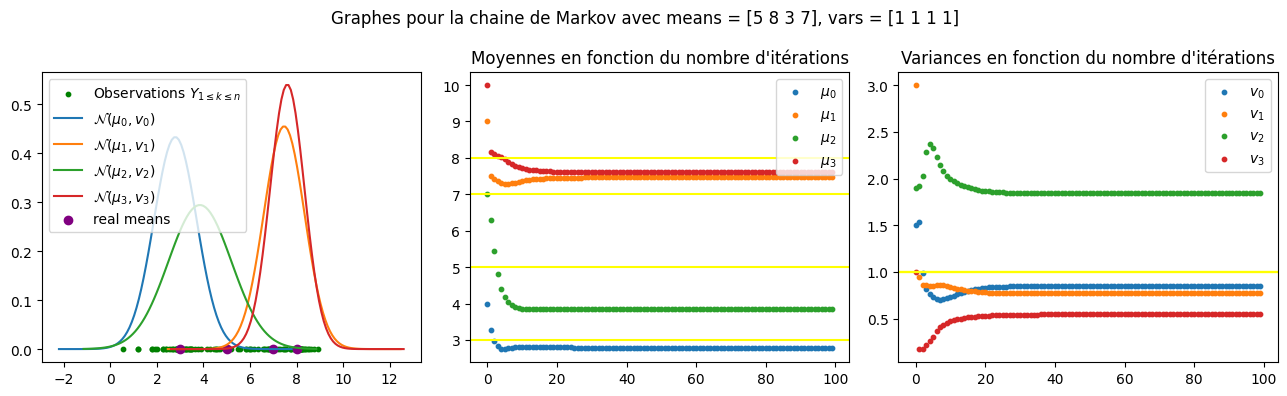

 moyennes = [2.78974125 7.46526788 3.84580716 7.60136811]
 variances = [0.84971143 0.76963012 1.84124919 0.5457718 ]


In [2234]:
means_init = np.array([4.,9.,7.,10.])
vars_init = np.array([1.5,3.,1.9,1.])
nb_iters = 100
theta_init = (Q,nu,means_init,vars_init)

means_result,vars_result,liste_means,liste_vars,log_likelihoods = EM_test_simple(Y,theta_init,nb_iters,X)
affichage(Y,means_result,vars_result,liste_means,liste_vars,nb_iters,means,vars)
print(f" moyennes = {means_result}")
print(f" variances = {vars_result}")

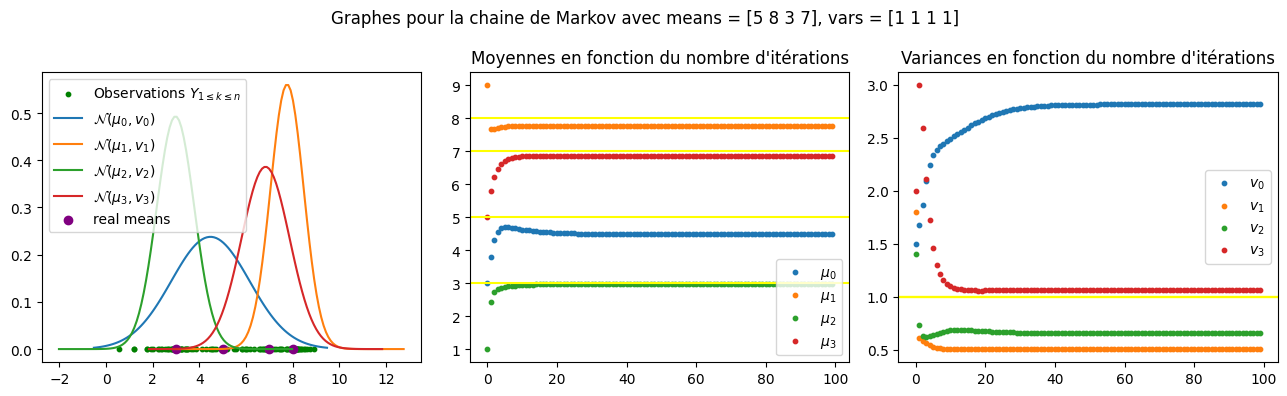

 moyennes = [4.47985472 7.7676605  2.98161694 6.84416055]
 variances = [2.81570814 0.50629741 0.6548635  1.06711984]


In [2235]:
means_init = np.array([3.,9.,1.,5.])
vars_init = np.array([1.5,1.8,1.4,2.])
theta_init = (Q,nu,means_init,vars_init)

means_result,vars_result,liste_means,liste_vars,log_likelihoods = EM_test_simple(Y,theta_init,nb_iters,X)
affichage(Y,means_result,vars_result,liste_means,liste_vars,nb_iters,means,vars)
print(f" moyennes = {means_result}")
print(f" variances = {vars_result}")

In [2236]:
theta_init = means_result,vars_result,liste_means,liste_vars,log_likelihoods_alea = EM_test_simple(Y,theta_init,nb_iters,X)
log_likelihood_res_max = log_likelihoods_alea[log_likelihoods_alea.size -1]
best_means = means
best_vars = vars
nb_iters = 100

In [2237]:
"""for i in range(50):
    means_init = np.random.uniform(low=-1.0, high=8.0, size=4)
    vars_init = np.random.uniform(low=0.3, high=2.0, size=4)
    theta_init = (Q,nu,means_init,vars_init)
    means_result,vars_result,liste_means,liste_vars,log_likelihoods_alea = EM_test_simple(Y,theta_init,nb_iters,X)
    log_likelihood_res = log_likelihoods_alea[log_likelihoods_alea.size -1]
    #print(log_likelihood_res )
    if log_likelihood_res >= log_likelihood_res_max :
        log_likelihood_res_max = log_likelihood_res
        best_means = means_result
        best_vars = vars_result
        #print(best_means)"""

C:\Users\Melvin\AppData\Local\Temp\ipykernel_19704\2775683019.py:21: RuntimeWarning: invalid value encountered in divide
  omega[k,:] = omega[k,:] / np.sum(omega[k,:])


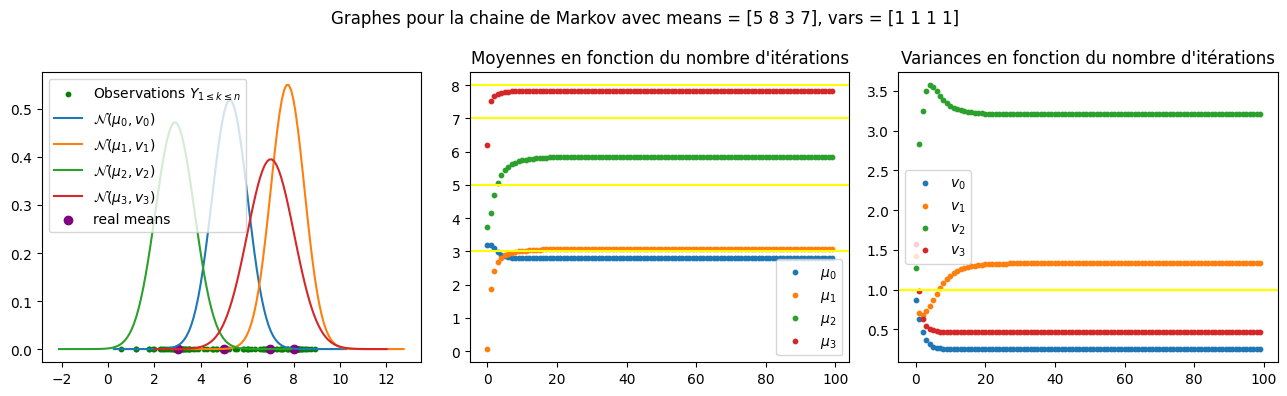

 moyennes = [2.79213254 3.0713997  5.84210731 7.81832584]
 variances = [0.25332334 1.33314307 3.20320861 0.46352499]


In [2238]:
affichage(Y,best_means,best_vars,liste_means,liste_vars,nb_iters,means,vars)
print(f" moyennes = {means_result}")
print(f" variances = {vars_result}")

Pour la deuxième chaine de markov, la convergence dépend beaucoup des données initales, comme on peut le voir sur les 3 premiers graphes.
Pour le dernier graphe, on génère aléatoirement les conditions initales et on garde celle qui maximise la log_vraissemblance de l'EM.
Pour un grand nombre de génération alétoire de parmètre on obtient une plûtot bonne approximationd des paramètres de l'EM.

Pour nos deux premières chaines de markov simple, l'algo EM converge bien vers les bonnes valeurs, nous nous sommes assurer de choisir les bonnes conditions intiales à la main, et le bon nombre d'observations -> pas trop grand, les moyennes pas trop espacé, et un nombre d'itération suffissant.
IL y a plus choses à préciser sur ces graphes.
D'abord nous nous assurons que notre algorithme EM augmente bien la log vraissemblance. la log est compliqué des données observés est difficle à calculer car une somme compliqué apparait. Pour l'approcher on utilise une méthode de mont. Mais comme il a beacuoup de réalisations de la chaine de markov, on ne reproduira l'éxécution dans, on a sauvegegardé les donnés dans un fichier texte. Aussi l'em est très sensible aux conditions initales, on a donc généré aléatoriement des conditions initales pour exécuter l'algo EM, et on s'est assuré de chosir à chaque fois une conditions initale qui augmente la log-likeliood.

 L'algo EM est aussi très sensible aux nombres d'observations et d'itérations, cela est du aux probabilités calculés dans notres em, nottament les quantités alpha et beta qui interviennent dans le calcul des omega. Pour éviter ce problème on s'est assuré de ne pas choisir des nombres d'observations trop élévés, sinon il a de petites probaiblités qui interviennent et elles vont être considéré comme zero comme elles sont trop petites. On n'as essaye de mettre aux logs mais cela pose problème puisque il est possbible que des probab soit très petites et d'autres très proche 1. Par exemple dans le quotient des omegas, ça ne fonctionne pas et ça fausse totalement l'EM. Quantité qui pose problème dans l'EM -> trop grand nombre d'observations,
données initales, moyennes trop espacés. Pour illustrer cela nous allons nous concentrer sur le 4ème graphe.
Nous illustrons tout cela grâce à notre 3ème graphe.

Problème du projet : le rescaling !!

<font color=red> On met à jours toutes les observations </font>

#### <font color=darkorange>  IIII - Méthode de Gradient </font>


\begin{equation*}
\begin{aligned}
\nu_i^{\theta} &\leftarrow \nu_i^{\theta} + \alpha \sum_{k=0}^n \omega_k^{\theta\prime}(i) \ \newline
\mu_i^{\theta} &\leftarrow \mu_i^{\theta} + \alpha \sum_{k=0}^n \frac{(y_k - \mu_i^{\theta})\omega_k^{\theta\prime}(i)}{v_i^{\theta}} \ \newline
v_i^{\theta} &\leftarrow v_i^{\theta} + \alpha \left(\sum_{k=0}^n \frac{\omega^{\theta\prime}_{k}(i)}{v_i^{\theta}} - \sum_{k=0}^n \frac{(y_k - \mu_i^{\theta})\omega_k^{\theta\prime}(i)}{(v_i^{\theta})^2}\right) \ \newline
q_{i j}^{\theta} &\leftarrow q_{i j}^{\theta} + \alpha \sum_{k=0}^{n-1} \omega_{k,k+1}^{\theta\prime}(i,j)
\end{aligned}
\end{equation*}

Note : Le symbole $\alpha$ représente le taux d'apprentissage (learning rate) de la méthode de gradient et $\omega^{\theta\prime}$ représente la distribution des variables latentes dans le modèle.



In [2239]:
def descente_gradient(Y,Q_init,nu_init,means_init,vars_init,nb_iters):
    n = Y.size
    r = nu_init.size 
    y = Y
    Q = Q_init
    nu = nu_init
    means = means_init
    vars = vars_init
    print(vars)
    for k in range(nb_iters): # mise à jour de la moyenne
        omega = omega_now(y,Q,nu,means,vars) 
        for i in range(r):
            print(vars)
            means[i] = means[i] + 0.01 * np.sum( (y-means[i]) * omega[:,i] ) / (vars[i])
            vars[i] = vars[i] - 0.01 * ( (np.sum(omega[:,i])) / (2*vars[i]) - np.sum( ((y-means[i]) * omega[:,i])**2 )  / (2 *(vars[i])**2))
            print(vars)
    return means,vars

descente_gradient(Y,Q,nu,means_init,vars_init,nb_iters)


[0.25332334 1.33314307 3.20320861 0.46352499]


TypeError: omega_now() takes 2 positional arguments but 5 were given